<a href="https://colab.research.google.com/github/EmjayAhn/study_deeplearning/blob/master/05_FFNN_modeling_(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.enable_eager_execution()

## MNIST 학습 시키기


이번 예제에서는 MNIST를 학습시켜본다. <br>
MNIST라고 하면 손글씨 이미지라고 생각하면 쉽다. <br>
0 ~ 9까지 적혀있는 손글씨 이미지를 숫자별로 분류하면 된다. <br><br>
이 예제에서는 FFNN을 이용하여 MNIST 이미지를 분류해볼 것이다.

### example 1

MNIST는 tf.keras 내부 API를 이용하여 다운받을 수 있다. <br>
이렇게 데이터를 준비하면 바로 모델을 설계하면 된다. <br><br>

MNIST는 학습 데이터와 테스트 데이터 (validation set이라고 봐도 무방하다)를 별도로 제공한다.<br>
학습 데이터는 학습용으로 사용하고 validation set은 evaluation 할 때 사용하도록 한다.


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255., x_test/255.

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


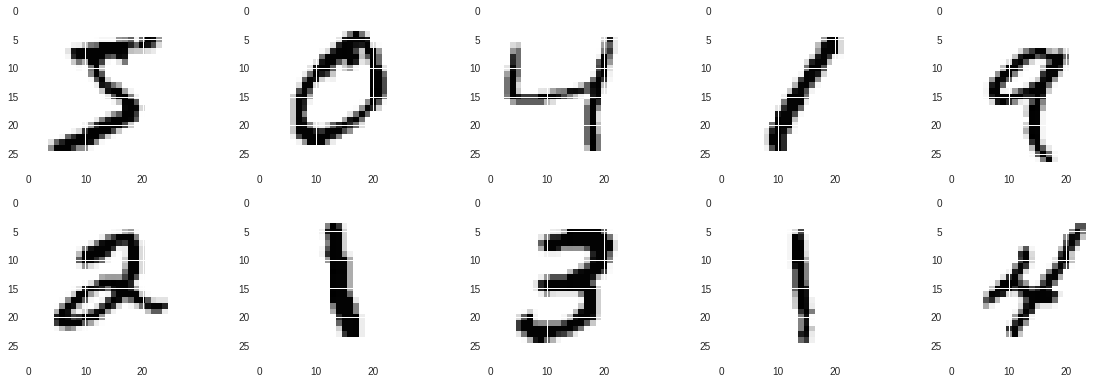

In [0]:
plt.figure(figsize=(20,10))
columns = 5
images = x_train[:10]
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

다른 부분은 이전 모델과 거의 흡사하지만 multi-class 라는 점에서 차이가 있다. <br>
기존 모델에서는 출력이 1개인 output layer를 다뤘지만 여기서는 output이 10개 이므로, binary classifier인 sigmoid함수는 적절하지 않다. <br><br>

여기서는 softmax 함수를 활용한다.

\begin{equation}
  \frac{e^{wx}}{\sum_{k=1}^{K}e^{wx}}
\end{equation}

<br>

간단하게 말하면 softmax는 sigmoid를 normalize 한 형태라고 볼 수도 있다.<br>
이 때 loss에도 다음과 같은 변화가 생긴다.

\begin{equation}
  \textbf{L} = \sum_{i = 1}^{n}[-y_i\log{\hat{y}_i}]
\end{equation}

이는 tf.keras에서 sparse_categorical_crossentropy로 정의된다. <br>
이에 따라 accuracy도 binary accuracy가 아닌 sparse_categorical_accuracy를 써야한다. <br> 
기능은 동일하지만 binary와 categorical 은 연산에 있어 약간의 차이를 보인다.

In [0]:
inputs = tf.keras.Input(shape=x_train.shape[1:])

flat = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(10, activation=tf.nn.relu)(flat)
x = tf.keras.layers.Dense(10, activation=tf.nn.relu)(x)
out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(x)

model = tf.keras.Model(inputs=inputs, outputs=out)
model.compile(optimizer=tf.train.GradientDescentOptimizer(1e-2),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=[tf.keras.metrics.sparse_categorical_accuracy])

model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
60000/60000 [==============================] - 6s 93us/step - loss: 1.0291 - sparse_categorical_accuracy: 0.6818
Epoch 2/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.4418 - sparse_categorical_accuracy: 0.8719
Epoch 3/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.3757 - sparse_categorical_accuracy: 0.8900
Epoch 4/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.3400 - sparse_categorical_accuracy: 0.9012
Epoch 5/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.3139 - sparse_categorical_accuracy: 0.9092
Epoch 6/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.2907 - sparse_categorical_accuracy: 0.9160
Epoch 7/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.2728 - sparse_categorical_accuracy: 0.9224
Epoch 8/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.2604 - sparse_categorical_accuracy: 0.9250
Epoch 9/

트레이닝이 완료되면 model 객체의 evaluate method를 통해 evaluation을 수행할 수 있다.

In [0]:
eval = model.evaluate(x_test, y_test)
print(eval)

10000/10000 [==============================] - 1s 71us/step
[0.24817505538016557, 0.9292]


In [0]:
pred = model.predict(x_test[:10])

for l, p in list(zip(y_test, pred)):
  print(l, p.argmax())

7 7
2 2
1 1
0 0
4 4
1 1
4 4
9 9
5 6
9 9


#### example 2

일반적으로 evaluate은 training과 함께 수행하는 경우가 많으므로 다음과 같이 fit method에서 validation set을 직접 넣어주어 training간 evaluation을 동시에 해줄 수 있다.

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255., x_test/255.

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [0]:
inputs = tf.keras.Input(shape=x_train.shape[1:])

flat = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(10, activation=tf.nn.relu)(flat)
x = tf.keras.layers.Dense(10, activation=tf.nn.relu)(x)
out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(x)

model = tf.keras.Model(inputs=inputs, outputs=out)
model.compile(optimizer=tf.train.GradientDescentOptimizer(1e-2),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=[tf.keras.metrics.sparse_categorical_accuracy])

model.fit(x_train, 
          y_train, 
          batch_size=32, 
          epochs=10, 
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 104us/step - loss: 1.1967 - sparse_categorical_accuracy: 0.6133 - val_loss: 0.6232 - val_sparse_categorical_accuracy: 0.8079
Epoch 2/10
60000/60000 [==============================] - 6s 99us/step - loss: 0.5650 - sparse_categorical_accuracy: 0.8280 - val_loss: 0.4686 - val_sparse_categorical_accuracy: 0.8546
Epoch 3/10
60000/60000 [==============================] - 6s 99us/step - loss: 0.4615 - sparse_categorical_accuracy: 0.8653 - val_loss: 0.4043 - val_sparse_categorical_accuracy: 0.8776
Epoch 4/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.4023 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.3622 - val_sparse_categorical_accuracy: 0.8918
Epoch 5/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.3609 - sparse_categorical_accuracy: 0.8968 - val_loss: 0.3296 - val_sparse_categorical_accuracy: 0.9026
Epoch 6/10
60000/60000

In [0]:
pred = model.predict(x_test[:10])

for l, p in list(zip(y_test, pred)):
  print(l, p.argmax())

7 7
2 2
1 1
0 0
4 4
1 1
4 4
9 9
5 6
9 9
